In [235]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook
from scipy.sparse import issparse
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
%matplotlib inline
#feature and dimension expand, why?
#what if we only use original features?
#Assume we have five orignal features: amt, paymtd, paytype, RecorPay, beneficiary
#dictionary for each feature is as following, all features are categorical data:
##Amt:0-9 (Amount of each txn)
##Paymtd:0-9 (payment method of each txn)
##Paytype:0-9 (payment type of each txn)
##RecorPay:0-9 (receive or pay type of each txn)
##bene:0-9 (beneficiary of each txn)

class Sythetic:
    def __init__(self):
        print('Sythetic instance has been created!')
        
    def Kmeans(self,data,K,plt):
        sse = {}
        t0=time()
        for k in tqdm_notebook(range(1, K+1)):
            kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
            sse[k] = kmeans.inertia_ 
        t1=time()
        plt.plot(list(sse.keys()), list(sse.values()))
        plt.set_title('Kmeans')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("SSE")
        print('Kmeans running time:%f sec!'%(t1-t0))
        return sse
        
    def SVD(self,data,K,plt):
        t0=time()
        svd=TruncatedSVD(n_components=K,n_iter=500,random_state=0)
        svd.fit(data)
        sigma=svd.singular_values_
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,sigma)
        plt.set_title('SVD')
        plt.set_xlabel("Singular Value Position")
        plt.set_ylabel("Singular Value")
        print('SVD running time:%f sec!'%(t1-t0))
        return sigma, svd.explained_variance_ratio_,svd.explained_variance_ratio_.sum()
        
    
    def PCA(self,data,K,plt):
        sparse=issparse(data)
        t0=time()
        pca = PCA(n_components=K)
        if sparse:
            pca.fit(data.toarray())
        else:
            pca.fit(data)
        sigma=pca.singular_values_
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,sigma)
        plt.set_title('PCA')
        plt.set_xlabel("Singular Value Position")
        plt.set_ylabel("Singular Value")
        print('PCA running time:%f sec!'%(t1-t0))
        return sigma, pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum()
        
    def NMF(self,data,K,plt):
        re = {}
        t0=time()
        for k in tqdm_notebook(range(1, K+1)):
            nmf = NMF(n_components=k, max_iter=1000).fit(data)
            re[k] = nmf.reconstruction_err_  
        t1=time()
        plt.plot(list(re.keys()), list(re.values()))
        plt.set_title('NMF')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("Reconstruction-error")
        print('NMF running time:%f sec!'%(t1-t0))
        return re
    
    def LDA(self,data,K,plt):
        t0=time()
        coherence_values = []
        data=[[str(word) for word in doc] for doc in data]
        id2word=corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]
        for num_topics in tqdm_notebook(range(1,K+1)):
            model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=num_topics, 
                                                   random_state=0,
                                                   update_every=1,
                                                   alpha='auto',
                                                   per_word_topics=True)
            coherencemodel = CoherenceModel(model=model, texts=data, dictionary=id2word, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        t1=time()
        x=[i for i in range(1,K+1)]
        plt.plot(x,coherence_values)
        plt.set_title('LDA')
        plt.set_xlabel("Number of cluster")
        plt.set_ylabel("Coherence score")
        print('LDA running time:%f sec!'%(t1-t0))
        return coherence_values

    def Kmeans_pred(self,data,K,real_label):
        kmeans=KMeans(n_clusters=K,max_iter=1000)
        kmeans_pred=kmeans.fit_predict(data)
        conf_mat=confusion_matrix(real_label,kmeans_pred)
        return kmeans_pred,conf_mat
    
    def NMF_pred(self,data,K,real_label):
        nmf=NMF(n_components=K, max_iter=1000)
        W=nmf.fit_transform(data)
        nmf_pred=[np.argmax(i) for i in W]
        conf_mat=confusion_matrix(real_label,nmf_pred)
        return nmf_pred,conf_mat
    
    def LDA_pred(self,data,K,real_label):
        data=[[str(word) for word in doc] for doc in data]
        id2word=corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=K, 
                                               random_state=0,
                                               update_every=1,
                                               alpha='auto',
                                               per_word_topics=True)
        topic_dist=model.get_document_topics(corpus)
        topic_dist=[list(zip(*i))[1] for i in list(topic_dist)]
        LDA_pred=[np.argmax(np.array(i)) for i in topic_dist]
        conf_mat=confusion_matrix(real_label,LDA_pred)
        return LDA_pred,conf_mat
    
    def sub_plot_K(self,data,K):
        fig = plt.figure(figsize=(18,10))
        ax1=fig.add_subplot(231)
        self.Kmeans(data,K,ax1)
        ax2=fig.add_subplot(232)
        self.SVD(data,K,ax2)
        ax3=fig.add_subplot(233)
        self.PCA(data,K,ax3)
        ax4=fig.add_subplot(234)
        self.NMF(data,K,ax4)
        ax5=fig.add_subplot(235)
        self.LDA(data,K,ax5)
        plt.show()
        
    def conf_mat(self,data,K,real_label):
        print('*********K-means*********')
        print(s.Kmeans_pred(data,K,real_label)[1])
        print('*********NMF*************')
        print(s.NMF_pred(data,K,real_label)[1])
        print('*********PCA*************')
        sparse=issparse(data)
        if sparse:
            print(s.Kmeans_pred(PCA(K).fit_transform(data.toarray()),K,real_label)[1])
        else:
            print(s.Kmeans_pred(PCA(K).fit_transform(data),K,real_label)[1])
        print('*********SVD**************')
        print(s.Kmeans_pred(TruncatedSVD(K).fit_transform(data),K,real_label)[1])
        print('*********LDA**************')
        print(s.LDA_pred(data,K,real_label)[1])
        
s=Sythetic()

Sythetic instance has been created!


In [236]:
#suppose we have three class of txn as following:
##txn_class1:Amt always in bin 0
##txn_class2:Amt always in bin 5
##txn_class3:Amt always in bin 9
###We want to use our models to find such three kinds of txn_class
class txn_generator(Sythetic):
    
    def __init__(self):
        #super().__init__()
        print('txn_generator instance has been created!')
        
    def txn_class1(self):
        amt=np.random.choice(10,1,p=[0.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,1.0])[0] #feature amt will always be 9 in this class
        paymed=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        paytype=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        RecorPay=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        bene=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        return [amt,paymed,paytype,RecorPay,bene]


    def txn_class2(self):
        amt=np.random.choice(10,1,p=[1.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]#feature amt will always be 0 in this class
        paymed=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        paytype=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        RecorPay=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        bene=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        return [amt,paymed,paytype,RecorPay,bene]

    def txn_class3(self):
        amt=np.random.choice(10,1,p=[0.0,0.0,0.0,0.0,1.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]#feature amt will always be 4 in this class
        paymed=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        paytype=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        RecorPay=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        bene=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        return [amt,paymed,paytype,RecorPay,bene]
    
    def txn_class4(self):
        amt=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,  #this is single item pattern!
                                    0.1,0.1,0.1,0.1,0.1])[0] #feature bene will always be 9 in this class. 
        paymed=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,  #this is single item pattern!
                                    0.1,0.1,0.1,0.1,0.1])[0]
        paytype=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        RecorPay=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        bene=np.random.choice(10,1,p=[0.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,1.0])[0]
        return [amt,paymed,paytype,RecorPay,bene]

    def txn_class5(self):# two-interactive
        amt=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0] 
        paymed=np.random.choice(10,1,p=[0.0,1.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]
        paytype=np.random.choice(10,1,p=[0.0,1.0,0.0,0.0,0.0, #when paymed is 1, paytype will always be 1 as well.
                                    0.0,0.0,0.0,0.0,0.0])[0]  #this is two-interactive iterms pattern
        RecorPay=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        bene=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        return [amt,paymed,paytype,RecorPay,bene]

    def txn_class6(self):# five-interactive
        amt=np.random.choice(10,1,p=[1.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0] #all features are 0, this is five-interactive items pattern!
        paymed=np.random.choice(10,1,p=[1.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]
        paytype=np.random.choice(10,1,p=[1.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]
        RecorPay=np.random.choice(10,1,p=[1.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]
        bene=np.random.choice(10,1,p=[1.0,0.0,0.0,0.0,0.0,
                                    0.0,0.0,0.0,0.0,0.0])[0]
        return [amt,paymed,paytype,RecorPay,bene]


    def noisy(self):
        amt=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,  
                                    0.1,0.1,0.1,0.1,0.1])[0] 
        paymed=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,  
                                    0.1,0.1,0.1,0.1,0.1])[0]
        paytype=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        RecorPay=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        bene=np.random.choice(10,1,p=[0.1,0.1,0.1,0.1,0.1,
                                    0.1,0.1,0.1,0.1,0.1])[0]
        return [amt,paymed,paytype,RecorPay,bene]
 

    def txn_mat(self,prob=[0,0,0,0,0,0,1],num_txn=100,num_pattern=1):
        if (sum([i!=0 for i in prob])!=num_pattern):
            print('the number of pattern you set up does not match the prob!') 
            return None #num of non-zero items in prob should equal num_pattern 
        else:
            txn_mat=[]
            real_label=[]
            num_each_class_txn=[int(i*num_txn) for i in prob]
            txn_class=[self.txn_class1,self.txn_class2,
                       self.txn_class3,self.txn_class4,
                       self.txn_class5,self.txn_class6,
                       self.noisy]
            for idx,txn in enumerate(txn_class):
                txn_mat.extend([txn() for i in range(num_each_class_txn[idx])])
                real_label.extend([idx for i in range(num_each_class_txn[idx])])
            
            return txn_mat,real_label

txn=txn_generator()

txn_generator instance has been created!


In [237]:
class cust_generator(txn_generator):
    
    def __init__(self):
        #super().__init__()
        print('cust_generator instance has been created!')

    def pairwise(self,data):
        mat=[]
        for s in data:
            row=[]
            for i in range(len(s)-1):
                for j in range(i+1,len(s)):
                    row.append(s[i]+'_'+s[j])
            mat.append(row)
        return mat
    
    def count_vect(self,data):
        count=CountVectorizer()
        sentence=[' '.join(i) for i in data]
        count_mat=count.fit_transform(sentence)
        return count_mat
    
    def cust_single(self,prob_txn=[0,0,0,0,0,0,1],num_txn=100,num_txn_pattern=1,cust_label=0): # different cust class is only up to the prob 

        single_cust=super().txn_mat(prob_txn,num_txn,num_txn_pattern)[0]

        real_label=cust_label

        return single_cust, real_label

    def cust_single_to_doc(self, inter_items='one',cust_single=None,**cust_single_args):

        doc=[]
        
        if cust_single is not None:
            
            cust_single_mat,real_label=cust_single
            
            inter_1=[[str(idx)+'_'+str(j) for idx,j in enumerate(i) ] for i in cust_single_mat]
            
        else:
            
            cust_single_mat, real_label=self.cust_single(prob_txn=cust_single_args['prob_txn'],
                                                num_txn=cust_single_args['num_txn'],
                                                num_txn_pattern=cust_single_args['num_txn_pattern'],
                                                cust_label=cust_single_args['cust_label'])
            
            inter_1=[[str(idx)+'_'+str(j) for idx,j in enumerate(i) ]for i in cust_single_mat]
   

        if inter_items=='one':
            for i in inter_1:
                doc.extend(i)
            return doc, real_label

        elif inter_items=='two':
            inter_2=self.pairwise(inter_1)
            inter_2_np=np.array(inter_2)
            inter_1_np=np.array(inter_1)
            inter_2_1_np=np.append(inter_1_np,inter_2_np,axis=1)
            doc=inter_2_1_np.flatten()
            return doc, real_label
        
        elif inter_items=='full':
            inter_2=self.pairwise(inter_1) 
            inter_1_np=np.array(inter_1) 
            inter_2_np=np.array(inter_2)
            inter_2_1_np=np.append(inter_1_np,inter_2_np,axis=1)
            inter_full=[[str(j) for j in i]for i in cust_single_mat]
            inter_full=['_'.join(i) for i in inter_full]
            inter_full=[[i] for i in inter_full]
            inter_full_np=np.array(inter_full)
            inter_full_2_1_np=np.append(inter_2_1_np,inter_full_np,axis=1)
            doc=inter_full_2_1_np.flatten()
            return doc, real_label
        
        else:
            return None
        
    def cust_all(self,pattern=3,num_cust=[50,50,50],inter_items=['one','one','one'],
                                     prob_txn=[[1,0,0,0,0,0,0],
                                            [0,1,0,0,0,0,0],
                                            [0,0,0,0,0,0,1]],
                                     num_txn=[100,100,100],
                                     num_txn_pattern=[1,1,1],
                                     pattern_label=[0,1,2]):
            cust_mat=[]
            cust_label=[]
            for cust_pattern in range(pattern):
                for single_cust in range(num_cust[cust_pattern]):
                    doc,label=cust.cust_single_to_doc(inter_items=inter_items[cust_pattern], 
                                                    prob_txn=prob_txn[cust_pattern],
                                                    num_txn=num_txn[cust_pattern],
                                                    num_txn_pattern=num_txn_pattern[cust_pattern],
                                                    cust_label=pattern_label[cust_pattern])
                    cust_mat.append(doc)
                    cust_label.append(label)
                    
            return cust_mat,cust_label

cust= cust_generator()       

cust_generator instance has been created!



Kmeans running time:1.937043 sec!
SVD running time:0.235775 sec!
PCA running time:0.002007 sec!



NMF running time:0.704170 sec!



LDA running time:53.813800 sec!


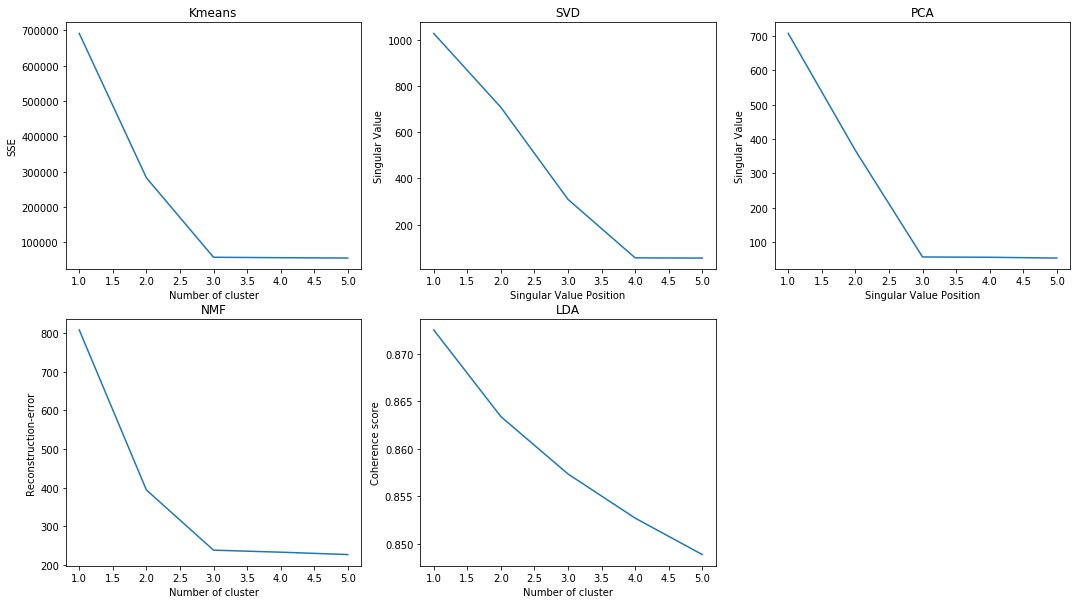

*********K-means*********
[[ 0 50  0]
 [ 0  0 50]
 [50  0  0]]
*********NMF*************
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
*********PCA*************
[[ 0  0 50]
 [50  0  0]
 [ 0 50  0]]
*********SVD**************
[[ 0  0 50]
 [ 0 50  0]
 [50  0  0]]
*********LDA**************
[[19 16 15]
 [17 19 14]
 [19 16 15]]


In [244]:
##### we use txn_mat func in txn class to generate all different pattern txn 
##### we can set up totally 7 kinds of different txn pattern from class1 to class7
##### the arguments of txn_mat func are as following:
"""
txn_mat(self,prob=[0,0,0,0,0,0,1],num_txn=100,num_pattern=1)

       1. prob=[0.3,0.3,0.4,0,0,0,0] has 7 dimension, which represents the ratio of
          total txn for each pattern.
          
       2. num_txn=150 is the total number of txn, so each pattern txn volumn 
          is the prob value times num_txn.
          
       3. num_pattern=3 is an error-proofing argument, this value should equal the
          number of non-zero elements of prob. since non-zero ratio of total txn is just
          the number of pattern of txn.
"""
##### we use cust_all func in cust class to generate all different pattern of customers 
##### the pattern of customer is determined by the distribution of this customer on all txn patterns!
##### For instance, cust-A has 100 txn, 90 txn are from txn-class1, 10 txn are from txn-class2.
##### cust-B has 100 txn, 100 txn are all from txn-class3. cust-A and cust-B are obvioulsy two 
##### different customer pattern.
##### the arguments of cust_all func are as following:
"""
 
cust_all(self,pattern=3,num_cust=[50,50,50],inter_items=['one','one','one'],
                                     prob_txn=[[1,0,0,0,0,0,0],
                                            [0,1,0,0,0,0,0],
                                            [0,0,0,0,0,0,1]],
                                     num_txn=[100,100,100],
                                     num_txn_pattern=[1,1,1],
                                     pattern_label=[0,1,2]):
                                     
       1. pattern=3: how many different cust-pattern, here we have three patterns
       
       2. num_cust=[50,50,50]: number of cust in each cust-pattern, 
          here 50 customers in each pattern
          
       3. inter_items=['one','one','one']: feature boosting method for 
          each cust-pattern. here all customers for each pattern use 
          one-order interactive items to perform feature boosting, which is just 
          dummy transformation. we have three options here: one-order, two-order, full-order. 
          We will set inter_items=['full','full','full'], if we want to get most significant 
          feature boosting.
          
       4. prob_txn=[[1,0,0,0,0,0,0],  pattern1 customer only has txn_class1 txn
                    [0,1,0,0,0,0,0],  pattern2 customer only has txn_class2 txn
                    [0,0,0,0,0,0,1]]  pattern3 customer only has txn_class3 txn
                    
       5. num_txn=[100,100,100]: average txn number for each customer unber a pattern
          Assume same pattern customer has similar number of txn during a fixed period of time.
          Later, we can use poisson random number instead of a fixed number.
          
       6. num_txn_pattern=[1,1,1]: notice the prob_txn, each cust-pattern only has one txn pattern.
          if all cust-pattern has 2 txn-pattern, then num_txn_pattern=[2,2,2]. 
          This arguments can help us identify txn-pattern from cust-pattern in sub_plt_K chart.
          
       7. pattern_label=[0,1,2]: the pattern label for each customer.
"""
##let's see if all models can identify each customer pattern based on default arguments value.
cust_mat, cust_label=cust.cust_all() 
count_mat=cust.count_vect(cust_mat)
s.sub_plot_K(count_mat,5)
s.conf_mat(count_mat,3,cust_label)


Kmeans running time:1.112848 sec!
SVD running time:0.185937 sec!
PCA running time:0.001003 sec!



NMF running time:0.705891 sec!



LDA running time:54.302175 sec!


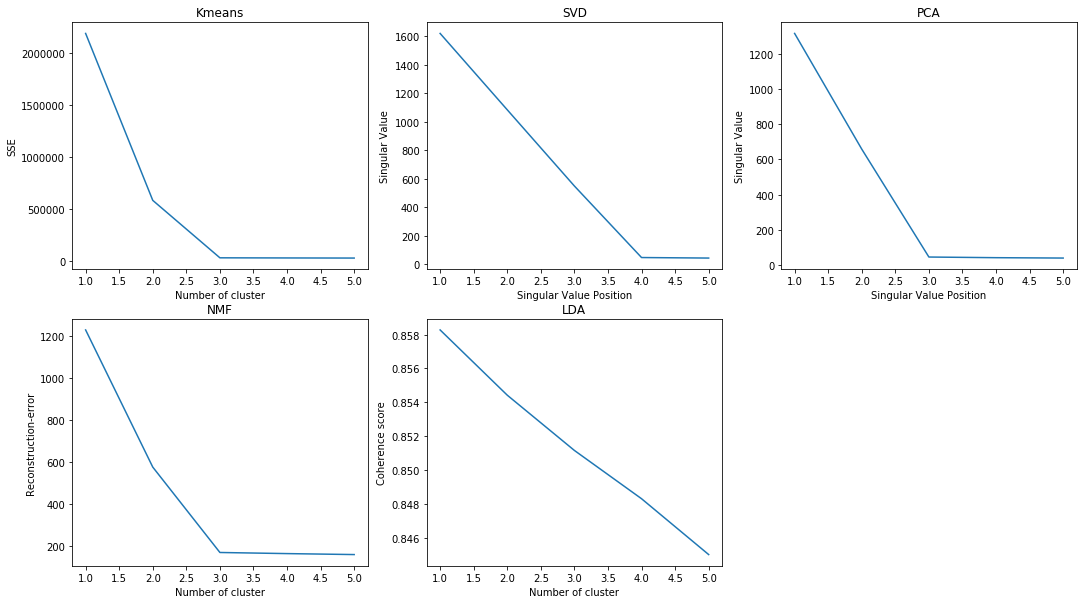

*********K-means*********
[[ 0  0 50]
 [50  0  0]
 [ 0 50  0]]
*********NMF*************
[[ 0  0 50]
 [ 0 50  0]
 [50  0  0]]
*********PCA*************
[[ 0  0 50]
 [ 0 50  0]
 [50  0  0]]
*********SVD**************
[[ 0 50  0]
 [ 0  0 50]
 [50  0  0]]
*********LDA**************
[[15 16 19]
 [17 13 20]
 [ 0 50  0]]


In [248]:
## what if we design a more complexed pattern and use full-order feature boosting to
## minging the customer pattern?
cust_mat, cust_label=cust.cust_all(pattern=3,num_cust=[50,50,50],inter_items=['one','one','one'],
                                 prob_txn=[[.5,.5,0,0,0,0,0], #this cust-pattern has two kind of
                                        [0,0,0,0,1,0,0],      # txn-pattern with txn_class1 and
                                        [0,0,0,0,0,1,0]],     # txn_class2
                                 num_txn=[100,100,100],
                                 num_txn_pattern=[2,1,1],#so here num_txn_pattern of cust-pattern1=2
                                 pattern_label=[0,1,2])     
count_mat=cust.count_vect(cust_mat)
s.sub_plot_K(count_mat,5)
s.conf_mat(count_mat,3,cust_label)